In [1]:
# %%
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from astropy.table import Table
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
import inspect
import matplotlib.pyplot as plt
from astropy.time import Time
#
from astropy.io import ascii
from lmfit import Model


In [41]:
# %%
snrcut = 3
source = 'MOSFiT'
fittype = 'SNII-NMF'
verbose = True

# %%
path_model = f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}'
models = sorted(glob.glob(f'{path_model}/*.fits'))
print(f"{len(models)} models found") 

# %%
# path_sedinfo = f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/SED.INFO'
# infotbl = tablize_sedinfo(path_sedinfo, models)
infotbl = ascii.read(f'../model/PLAsTiCC/{fittype}/sedinfo.dat')
infotbl['model'] = [f"{path_model}/{model}" for model in infotbl['model']] 

384 models found


In [42]:
ii = 10
model = models[ii]
_mdtbl = Table.read(model)

indx = np.where(
    (_mdtbl['col1'] <= 30) &
    (_mdtbl['col2'] >= 2000) &
    (_mdtbl['col2'] <= 11000)
    # (_mdtbl['col2'] <= 10000)
)

In [43]:
mdtbl = _mdtbl[indx]
phasearr = np.unique(mdtbl['col1'])
nphase = len(phasearr)
lamarr = np.unique(mdtbl['col2'])
nlam = len(lamarr)
number_of_unique_phase, number_of_unique_wavelength = len(phasearr), len(lamarr)
flux2darr = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

In [44]:
pc1arr = np.unique(infotbl['pc1'])
number_of_pc1 = len(pc1arr)
pc2arr = np.unique(infotbl['pc2'])
number_of_pc2 = len(pc2arr)
pc3arr = np.unique(infotbl['pc3'])
number_of_pc3 = len(pc3arr)

In [54]:
number_of_spectrums = len(infotbl)
length_of_spectrum = len(mdtbl)
length_of_total_arr = number_of_spectrums * length_of_spectrum
print(f"number of spectrum list: {number_of_spectrums}")
print(f"length of spectrum: {length_of_spectrum}")
print(f"length of total array: {length_of_total_arr}")

fluxarr = np.zeros(length_of_total_arr)
#	Each spectrum list
fluxarr = []
for ss, spec in enumerate(infotbl['model']):
	_ = Table.read(spec)[indx]
	fluxarr.append(_['col3'])
	# st = int((ss*length_of_spectrum)+ss*(length_of_spectrum))
	# ed = int((ss*length_of_spectrum)+(ss+1)*(length_of_spectrum))
	# fluxarr[st:ed] = np.array(_['col3'])

fluxarr = np.vstack(fluxarr)

#	Fold the flux array
data = fluxarr.reshape(number_of_pc1, number_of_pc2, number_of_pc3, nphase, nlam)


number of spectrum list: 384
length of spectrum: 22525
length of total array: 8649600


In [55]:
interp = RegularGridInterpolator((pc1arr, pc2arr, pc3arr, phasearr, lamarr), data, method='linear')


In [64]:
point = (
    infotbl['pc1'][20],
    infotbl['pc2'][30],
    infotbl['pc3'][40],
    phasearr[10],
    lamarr
)
iflux = interp(point)

(3750.0, 9000.0)

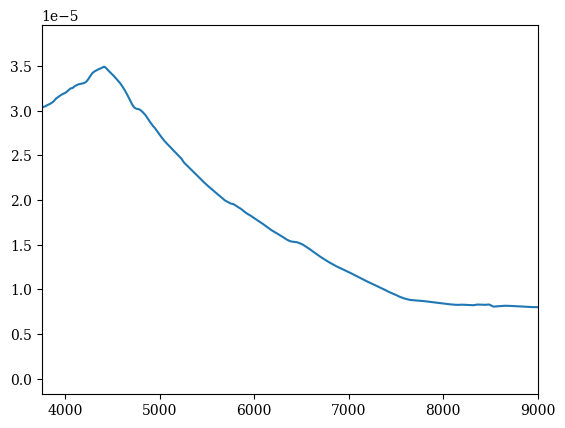

In [66]:
plt.plot(lamarr, iflux)
plt.xlim([3750, 9000])

In [67]:
path_pickle = '../model/PLAsTiCC/SNII-NMF/SNII.pickle'
if path_pickle is not None:
	print(f"Dumping interpolator to {path_pickle}...")
	with open(path_pickle, 'wb') as f:
		pickle.dump(interp, f)

print(f"\nDONE!\n")

Dumping interpolator to ../model/PLAsTiCC/SNII-NMF/SNII.pickle...

DONE!

